In [5]:
# Fix RC overwriting
%config InlineBackend.rc = {}

import k3d
import numpy as np
from IPython.display import Image
from IPython.utils.capture import capture_output
from matplotlib import pyplot as plt
from mplhep.styles import ROOT
from scipy.spatial import KDTree
from texat.tracking.model.interval import probability_point_line

plt.style.use(ROOT)
plt.rc("figure", figsize=(10, 5), dpi=120)
plt.rc('font', size="16")

# Track Finding and Fitting

## Tracking in TPCs

### Hough Transform


The _classical_ Hough Transform is a technique for estimating the parameters and multiplicity of a model family within a dataset. It employs a scheme whereby _features_ in the dataset, i.e. observations, vote for models with which they are compatible. For any continuous parametrisation, a single observation is a member of an infinite set of models. In order to make this tractable, the Hough Transform is conventionally performed by discretising the {math}`n`-dimensional parameter space of the model. Thereafter, for each observation, the set of compatible models can be determined from the permutations of the discrete {math}`n-1`-dimensional free parameter space.

:::{mermaid}
:caption: Flowchart detailing the classic discrete Hough Transform.

graph LR;
    start[Start]
    observation[Select observation]
    parameter_2[Select parameter #2]
    parameter_dots[...]
    parameter_n[Select parameter #n]
    compute_dependent[Compute parameter #1]
    accumulate_vote[Store vote]
    has_more_parameter_2{Another parameter #2?}
    has_more_parameter_n{Another parameter #n?}
    has_more_observation{Another observation?}
    find_peaks[Find peaks in vote space]
    stop[Stop]
    
    start-->observation
    observation --> parameter_2
    parameter_2 --> parameter_dots
    parameter_dots --> parameter_n
    parameter_n --> compute_dependent
    compute_dependent --> accumulate_vote
    accumulate_vote --> has_more_parameter_n
    has_more_parameter_n --> |Yes| parameter_n
    has_more_parameter_n --> |no| has_more_parameter_2
    has_more_parameter_2 --> |Yes| parameter_2
    has_more_parameter_2 --> |No| has_more_observation
    has_more_observation --> |Yes| find_peaks
    has_more_observation --> |No| observation
    find_peaks --> stop

:::

This technique introduces an explicit relationship between the precision of the identified model parameters and the robustness to noise; fine discretisations are able to accurately determine the underlying model parameters, but the introduction of noise quickly leads to the identification of multiple models. Meanwhile, coarse discretisations are far less vulnerable to over-fitting, but at a cost of poor parameter resolution. This tradeoff requires the user to balance the anticipated level of noise (signal-to-noise ratio) and the similarity of observations (how close any-two separate models are in parameter space. Furthermore, the search complexity increases exponentially with the number of model parameters.

Certain procedures can be used to mitigate this compromise:
- Bin smoothing: convolving the parameter space with a smoothing kernel to reduce the significance of spurious peaks
- Secondary optimisation: by asserting that identified models are close to their "true" representations, a secondary optimiser (e.g. least squares) can be used to improve the model parameters.

:::{admonition} To Do
:class: margin

Create figures to illustrate Hough Transform algorithm.
:::

### RANSAC 

Random Sample Consensus (RANSAC) is a paradigm for fitting a singular model to experimental data. It recognises the model finding/fitting problem as a connected one; the challenge of identifying a unique set of models within a dataset is highly dependent upon estimating their free parameters given the observed data.{cite:ps}`fischler_random_1981`

RANSAC draws a distinction between two kinds of error: 
- _measurement_ error: deviations from the "true" values observed in measurements)
- _classification_ error: gross errors that arise from misclassification of the dataset

The RANSAC procedure accounts for these two kinds of error by starting with a small, feasible, initial dataset, before enlarging this set with _consistent_ data. Concretely, when fitting e.g a line within a set of {math}`N` points, the RANSAC approach would be to select two points, compute origin and direction vectors, and then determine the points which lie within an acceptance window (orthogonal distance) to the model. These new _inliers_ can then be used to re-estimate the model; smoothing the measurement errors. 

:::{admonition} To Do
:class: margin

Create figures to illustrate RANSAC algorithm.
:::

:::{mermaid}
:caption: Flowchart outlining the RANSAC algorithm.

graph LR;
start[Start]
finish[Finish]
sample[Draw random sample]
fit[Fit model to subset]
test[Expand inliers]
refit[Fit concensus set]

loop{Drawn k trials?}
start --> sample
sample --> fit
fit --> test
test --> refit
refit --> loop
loop --> |No| sample
loop --> |yes| finish
:::

A number of parameters determine the termination of the algorithm, namely:
- the acceptance window that separates inliers from outliers
- the minimum support required to instantiate a model (the number of inliers required to consider the model _valid_)
- the number of (random) subsets to draw in the search for model candidates.

The upper bound on the number of trials required to select a "good" subset from the dataset can be determined mathematically. If {math}`w` is the probability that a selected data point is within the error tolerance of a given model, then the expectation value {math}`E(K)` of the number of trials {math}`k` required to select a subset of {math}`n` points is given by
:::{math}
E(k) &= b + 2(1-b)b + 3(1-b)^2b + \dots + i(1-b)^{i-1}b\dots\,,

     &= b\bqty{1 + 2a + 3a^2 + \dots + i a^{i-1} + \dots}\,,
:::
where {math}`b=w^n` and {math}`a=(1-b)`.

It can be shown that the above simplifies to
:::{math}
E(k) = \frac{1}{b} = w^{-n}
:::
(see {cite:ps}`fischler_random_1981`).

Although there is no analytic method for determining the minimum support required to instantiate a model, there exist methods by which to determine sensible values of this parameter for a given problem.

#### Sequential RANSAC

The RANSAC algorithm is designed to find the best-fit model given a dataset. In scenarios where there may be multiple models, RANSAC must be generalised to identify a family of concensus sets. A common approach is to use _Sequential_ RANSAC, which iteratively applies the RANSAC algorithm to the dataset until no further models can be identified with sufficient support. 

The RANSAC algorithm establishes a hard distinction between inliers and outliers. An important consequence of this behaviour is that the method is hierarchical: the first "winning" model has the greatest number of data points to choose from, whilst the final model has the least. As such, for models with overlapping observations, RANSAC can perform poorly.

(content:facility-location-problem)=
## Facility Location Problem
The previously explored methods of the Hough Transform and RANSAC are both _greedy_ methods; the order in which solutions are generated favours those models which are found first. The consequence of greedy optimisation is that the global solution across several models may not be optimal.

:::{admonition} To Do
:class: margin

Give a visual example of this
:::

In order obtain a _global_ solution to track labelling, the task must be reframed as a global optimisation problem. 
The facility location problem (FLP) is an optimization problem whose solution determines the optimal location for a set of facilities such that the transportation costs for each facility are minimised. There are several formulations of the problem with auxillary constraints, such as the _capacity_ of the facilities, or the addition of an _opening cost_ for each facility. 

The significance of "facility" and "transportation cost" depends upon the framing of the problem. Here, the _uncapacitated facility location problem_ (UFLP) will be explored in the context of particle track labelling.

### Uncapacitated Facility Location Problem
The uncapacitated facility location problem is a variant of the FLP in which each facility has an unlimited capacity and an associated opening cost. In prose, the problem may be defined by the following requirements
- A manufacturing company wants to minimise costs.
- Delivery is expensive, so facilities need to be close to consumers.
- Facilities are also expensive, so as few as possible should be opened.

The solution to this problem is given by the minimisation of the following cost function: 
:::{math}
:label: uflp-cost-function
E(F) = \sum_{f \in F} \left( O_f + \sum_{c \in C} T_{fc} D_{fc} \right)\,,
:::
where 
- {math}`F` is the set of open facilities.
- {math}`O_f` is the cost of opening facility {math}`f`.
- {math}`T_{fc}` is the cost of transporting goods between facility {math}`f` and consumer {math}`c`.
- {math}`D_{fc}` is the demand of consumer {math}`c` satisfied by facility {math}`f`.


In the domain of track labelling, the terms "facility", "distance", and "consumer", acquire new meaning:
```{list-table} Terms corresponding to the FLP interpretation of track labelling.
:name: flp-labelling-terms
:header-rows: 1

* - Term
  - Interpretation
* - Facility
  - A hypothetical track model
* - Consumer
  - An observation that belongs to an unknown track model
* - Transport cost
  - The goodness-of-fit for an observation given a particular track model
```

Meanwhile, the consumer demand {math}`D_{fc}` is simply the delta function of the labelling {math}`\delta_{ff(c)}`, i.e. a single observation {math}`c` is served by exactly one facility {math}`f(c)`. See {numref}`track-model-illustration` for an illustration of these components.

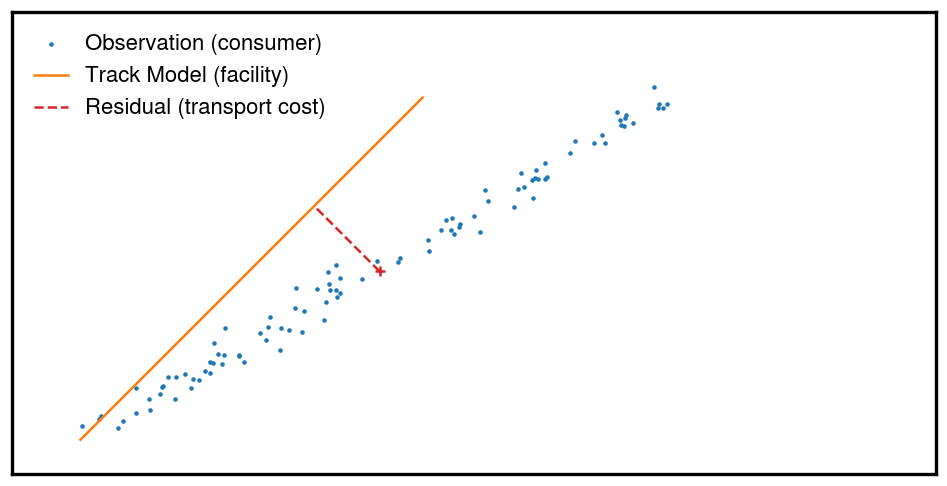

In [6]:
plt.figure()

n = 100

t = np.random.uniform(high=10.0, size=n)
w = np.random.normal(scale=0.15, size=n)
R = np.stack((w, t), axis=1)

x = np.radians(60)
M = np.sin([[np.pi / 2 - x, -x], [x, np.pi / 2 - x]])
S = R @ M

# Draw scatter
plt.scatter(S[:, 0], S[:, 1], s=3, label="Observation (consumer)")

# Draw model
Q = np.r_[5, 5]
plt.plot([0, Q[0]], [0, Q[1]], color="C1", label="Track Model (facility)")

# Random midpoint
i_midpoint = np.argmin(np.abs(S[:, 0] - 4.5))
P = S[i_midpoint]
plt.scatter(P[0], P[1], marker="+", color="C3")

# Intersection
tau = ((P - [0, 0]) @ Q) / (Q @ Q)
H = tau * Q

# Draw tangent
plt.plot(
    [P[0], H[0]],
    [P[1], H[1]],
    color="C3",
    linestyle="--",
    label="Residual (transport cost)",
)

plt.gca().set_aspect(1)
width = 13.5
plt.xlim(-5 + 4, -5 + 4 + width)
plt.ylim(-0.5, -0.5 + width / 2)
plt.tick_params(
    axis="both",
    which="both",
    left=False,
    bottom=False,
    top=False,
    right=False,
    labelbottom=False,
    labelleft=False,
)
plt.legend();

The probability of observing set {math}`C` of observations for facility $f$ is the product of the probabilities of observing each $c$, i.e. 
:::{math}
P(f \mid C) = \prod_c{P(f \mid c)}\,.
:::
If the per-consumer transport cost is given as a log-likelihood, then it follows that the sum over the transport costs for each facility is equivalent to the log-likelihood of the facility given {math}`C`:
:::{math}
:label: log-likelihood-sum

\sum_c{\ln\left({P(f \mid c)}\right)} 
&= \ln\left({\prod_c{P(f \mid c)}}\right)

&= \ln\left(P(f \mid C)\right)\,.
:::

### Metric Labelling Problem

The trivial form of {eq}`uflp-cost-function`, in which the facility cost {math}`O_f` is zero
:::{math}
:label: cost-function-trivial
E(F) = \sum_{f \in F,\,c \in C} T_{fc} D_{fc}\,,
:::
is ill-posed. A _well-posed_ problem is guaranteed to have a _unique_ solution that depends continuously on the input data.{cite:ps}`hadamard`

In order to solve {eq}`cost-function-trivial`, the set of admissable solutions must be restricted by the introduction of _a priori_ knowledge, i.e. the problem must be _regularised_. The label cost term given in {eq}`uflp-cost-function` is one such regulariser which imposes a preference for solutions with fewer labels.

A common feature of the labelling problem (of which the track labelling problem is a derivative) is that coherent groups of observations are typically known _a priori_ to be positively correlated. 

This behaviour can be accounted for by an additional regulariser in the energy function
:::{math}
:label: cost-smoothness
\sum_{cc'\in C}V_{f(c),f(c')}(c, c')\,,
:::
where {math}`V_{f(c),f(c')}(c, c')` is the pairwise prior that penalises {math}`f(c) \neq f(c')`, such that we have
:::{math}
:label: cost-function-pearl
E(F) = 
\underbrace{\sum_{f \in F} O_f}_{\text{label cost}} + 
\underbrace{\sum_{f \in F,\,c \in C} T_{fc} D_{fc}}_{\text{data cost}} + 
\underbrace{\sum_{cc'\in C}V_{f(c),f(c')}(c, c')}_{\text{smooth cost}}\,.
:::

A two dimensional model potential is shown in {numref}`smoothness-labelling-illustration`.

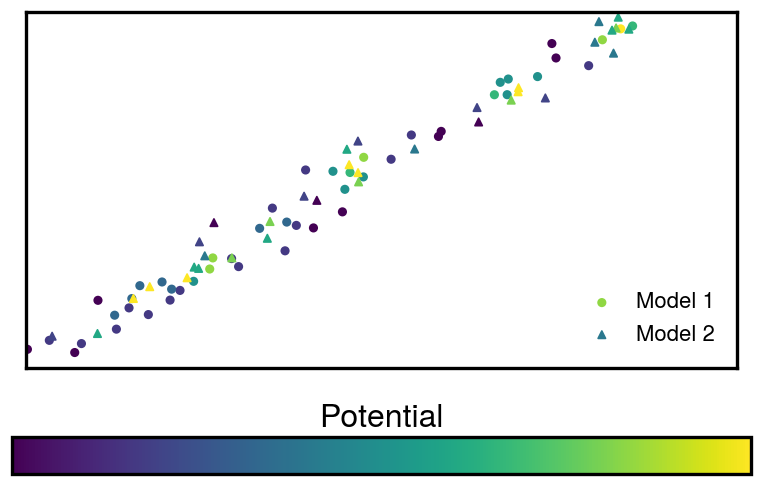

In [7]:
plt.figure()
tree = KDTree(S)

model = np.random.choice([1, 2], size=len(S))

pairs = tree.query_pairs(0.3, output_type="ndarray")
pair_costs = np.where(
    model[pairs[:, 0]] != model[pairs[:, 1]],
    np.sum((pairs[:, 0] - pairs[:, 1]) ** 2),
    0.0,
)

cost = np.zeros(len(S))
np.add.at(cost, pairs[:, 0], pair_costs)
np.add.at(cost, pairs[:, 1], pair_costs)


colors = np.array(plt.rcParams["axes.prop_cycle"].by_key()["color"])

# Draw scatter
plt.scatter(
    S[model == 1, 0],
    S[model == 1, 1],
    c=cost[model == 1],
    s=20,
    label="Model 1",
    marker="o",
)
plt.scatter(
    S[model == 2, 0],
    S[model == 2, 1],
    c=cost[model == 2],
    s=20,
    label="Model 2",
    marker="^",
)

plt.gca().set_aspect(1)
colorbar = plt.colorbar(orientation="horizontal", fraction=0.08)
colorbar.ax.set_title("Potential")
colorbar.ax.tick_params(
    axis="both",
    which="both",
    left=False,
    bottom=False,
    top=False,
    right=False,
    labelbottom=False,
    labelleft=False,
    labelright=False,
    labeltop=False,
)
plt.xlim(0, 8)
plt.ylim(0, 4)
plt.tick_params(
    axis="both",
    which="both",
    left=False,
    bottom=False,
    top=False,
    right=False,
    labelbottom=False,
    labelleft=False,
)
plt.legend(loc="lower right");

Clearly, the _label cost_ leads to minimisation of the model count, whilst the _smooth cost_ leads to the preference of spatially coherent labellings. As before, the _data cost_ prefers models which are well-described by their inliers.

:::{admonition} To Do
:class: margin

Mention constraints on potential (see [https://profs.etsmtl.ca/hlombaert/energy/#SECTION00010000000000000000](https://profs.etsmtl.ca/hlombaert/energy/#SECTION00010000000000000000))
:::

### Graph Cut Optimization

In the absence of smooth costs, the UFLP can be solved by integer programming techniques, but remains NP-hard.{cite:ps}`Cheriyan98approximationalgorithms` There exists an heuristic method which solves {eq}`uflp-cost-function` in {math}`\mathcal{O}(\lvert F\rvert^2 \lvert C \rvert)` time.{cite:ps}`kuehn_heuristic_1963` Meanwhile, task of minimising {eq}`cost-function-pearl` is also NP-hard for {math}`\lvert F \rvert \geq 3`,{cite:ps}`boykov_fast_2001-1` but there exist approximate solutions using _graph cuts_ that are guaranteed to find the local minima within a fixed bound of the global optimum.{cite:ps}`delong_fast_2010`

::::{admonition} NP-hardness
:class: dropdown

In computational complexity theory, _P_ problems are those problems of size {math}`n` for which the time {math}`T(n)` to determine their solutions is upper bounded by a polynomial in {math}`n`, i.e. {math}`T(n)=\mathcal{O}(n^k)`

_NP_ problems are those which cannot be _solved_ but can be _verified_ in polynomial time.

_NP-complete_ problems are NP problems to which all other NP problems can be reduced in polynomial time.

_NP-hard_ problems are _at least_ as complex as NP-complete problems, i.e. there must exist an NP-complete problem that can be transformed in polynomial time to an NP-hard problem.

:::{figure} https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/P_np_np-complete_np-hard.svg/640px-P_np_np-complete_np-hard.svg.png
:name: p-np-complete
:width: 512px
:align: center

Diagram illustrating the relationship between P, NP, NP-complete, and NP-hard problems under the assumptions of {math}`P=NP` and {math}`P\neq NP`
:::

::::

#### Graph Cuts

One family of approximations to the solution of {eq}`cost-function-pearl` are based upon the method of _graph cuts_. Here, the fundamentals of the {math}`\alpha`-expansion method will be discussed, with the treatment of label costs and {math}`\alpha\beta`-swap moves omitted for brevity.

Without label costs, {eq}`cost-function-pearl` becomes
:::{math}
:label: cost-function-graph
E(F) = 
\underbrace{\sum_{f \in F,\,c \in C} T_{fc} D_{fc}}_{\text{data cost}} + 
\underbrace{\sum_{cc'\in C}V_{f(c),f(c')}(c, c')}_{\text{smooth cost}}\,.
:::

A _graph_ {math}`\mathcal{G}(\mathcal{V}, \mathcal{E})` is fundamentally a set of vertices {math}`\mathcal{V}` and a set of pairwise edges {math}`\mathcal{E}` between them. Each edge may have an associated weight, and may further be directed such that {math}`A\rightarrow B` is distinct from {math}`A \leftarrow B`.

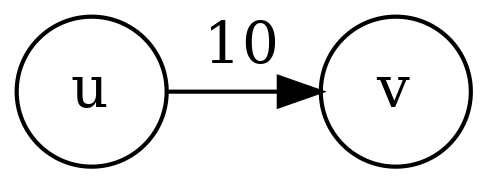

In [8]:
import base64
import subprocess


def format_dot(src, dpi):
    mime = {}
    result = subprocess.run(
        ["dot", "-T", "svg"], capture_output=True, input=src.encode("utf-8")
    )
    if result.returncode:
        mime["text/plain"] = result.stderr.decode()
    else:
        mime["image/svg+xml"] = result.stdout.decode()

        result = subprocess.run(
            ["dot", "-T", "png", f"-Gdpi={dpi:d}"],
            capture_output=True,
            input=src.encode("utf-8"),
        )
        mime["image/png"] = base64.b64encode(result.stdout).decode() + "\n"

    return mime


class DOT:
    def __init__(self, source, dpi=300):
        self.source = source
        self.dpi = dpi

    def _repr_mimebundle_(self, include=None, exclude=None):
        return format_dot(self.source, self.dpi)


DOT(
    """
    digraph my_graph {
        {rank = same; "u"; "v"}
        "u" [shape=circle];
        "v" [shape=circle];
        u -> v [label=10]
    }
    """
)

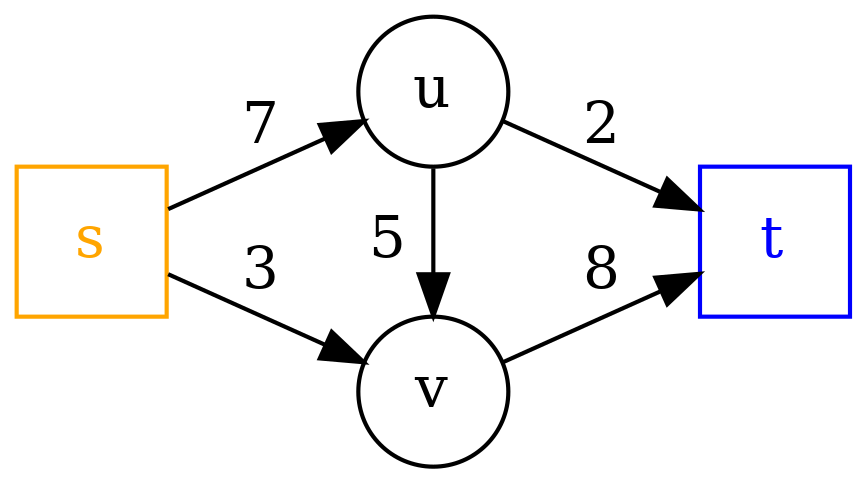

In [9]:
DOT(
    """
digraph my_graph {
    rankdir=LR;
    {rank = same; "u"; "v"}
    "s" [shape=square color=orange fontcolor=orange];
    "t" [shape=square color=blue fontcolor=blue];
    "u" [shape=circle];
    "v" [shape=circle];
    s -> u [label=7];
    s -> v [label=3];
    u -> t [label=2];
    v -> t [label=8];
    u -> v [label=5]
}
"""
)

A _cut_ {math}`\mathcal{C} \subset \mathcal{E}` is a set of edges which partitions the graph into two disjoint subsets, separating the terminals. Importantly, the _cost_ {math}`\lvert \mathcal{C} \rvert` equals the sum of the edge weights. Furthermore, no proper subset of {math}`\mathcal{C}` may also be a cut.

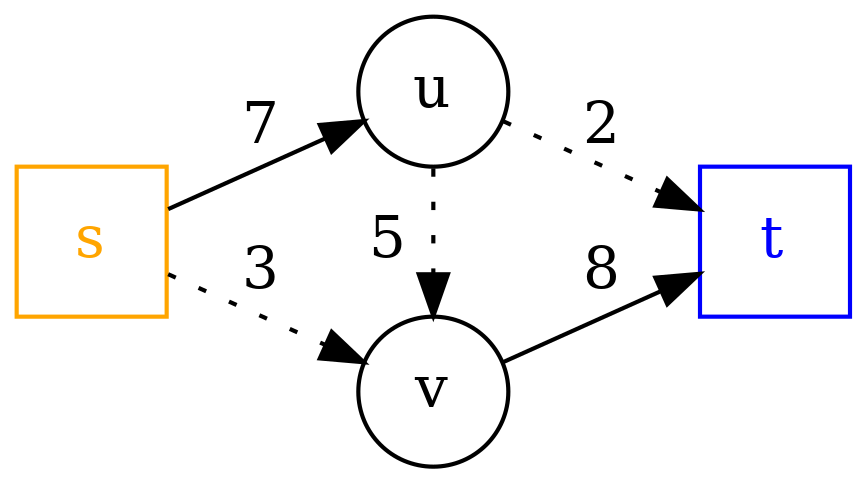

In [10]:
DOT(
    """
digraph my_graph {
    rankdir=LR;
    {rank = same; "u"; "v"}
    "s" [shape=square color=orange fontcolor=orange];
    "t" [shape=square color=blue fontcolor=blue];
    "u" [shape=circle];
    "v" [shape=circle];
    s -> u [label=7];
    s -> v [label=3 style=dotted];
    u -> t [label=2 style=dotted];
    v -> t [label=8];
    u -> v [label=5 style=dotted]
}
"""
)

Under the _min-cut max-flow_ theorem , the _minimum_-cut {math}`\mathcal{C}^\star` (cut for which {math}`\lvert \mathcal{C} \rvert` is minimal) is equivalent to the maximum-_flow_, which can be computed in an efficient manner.{cite:ps}`ford_maximal_1956`{cite:ps}`kolmogorov_what_2004` 

(alpha-expansion)=
#### Alpha Expansion
The {math}`\alpha`-expansion algorithm is a method of finding the labelling {math}`F` such that the potential {eq}`cost-function-graph` is minimised. It has been extended to solve {eq}`cost-function-pearl` through the treatment of label costs. The method is based upon the observation that, if {eq}`cost-function-graph` is encoded in terms of a particular graph construction {math}`G_{\alpha}`, the minimum cut corresponds to the optimal (local) labelling. The choice of this graph, and the mechanism by which the optimal labelling is determined by the minimum cut, will be outlined briefly below. 

Let us consider an example comprised of two nodes (observations) {math}`\Omega` and {math}`A`. We can introduce two labels: {math}`\alpha` and {math}`\omega`. The true labelling is given in {numref}`expansion-example-true-labelling`: the {math}`\Omega` is labelled by {math}`\omega`, and {math}`A` is labelled by {math}`\alpha`.

:::{list-table} Lowest cost (correct) labelling for a two-node system
:name: expansion-example-true-labelling
:header-rows: 1

* - Node
  - Label
* - {math}`A`
  - {math}`\alpha`
* - {math}`\Omega`
  - {math}`\omega`
:::

Although we already know that this labelling is the correct (optimal) one, let us imagine that we did not have this information. To determine whether the current labelling {math}`F` is a local minimum, one can use the _expansion-move_ algorithm to find an improved labelling {math}`F^\prime_\alpha` through the expansion of a particular label {math}`\alpha`. If the expansion does not modify the labelling, then it is optimal.

The optimal labelling given in ({numref}`expansion-example-true-labelling`) should have a cost that evaluates to

:::{math}
:label: expansion-minimum-cut-cost
E(F) = D(A\cdot \alpha) + D(\Omega \cdot \omega) + V(\Omega \cdot \omega,A\cdot \alpha)\,,
:::
i.e. the sum of 
- the data cost for {math}`A` under the {math}`\alpha` model
- the data cost for {math}`\Omega` under the {math}`\omega` model
- the smoothness cost between {math}`\Omega` under the {math}`\omega` model, and {math}`A` under the {math}`\alpha` model.

From the definition of the expansion-move, it follows that we can construct a graph {math}`G_\alpha` such that the minimum cut gives {eq}`expansion-minimum-cut-cost`. (see {numref}`graph-expansion-ocean-cut`).

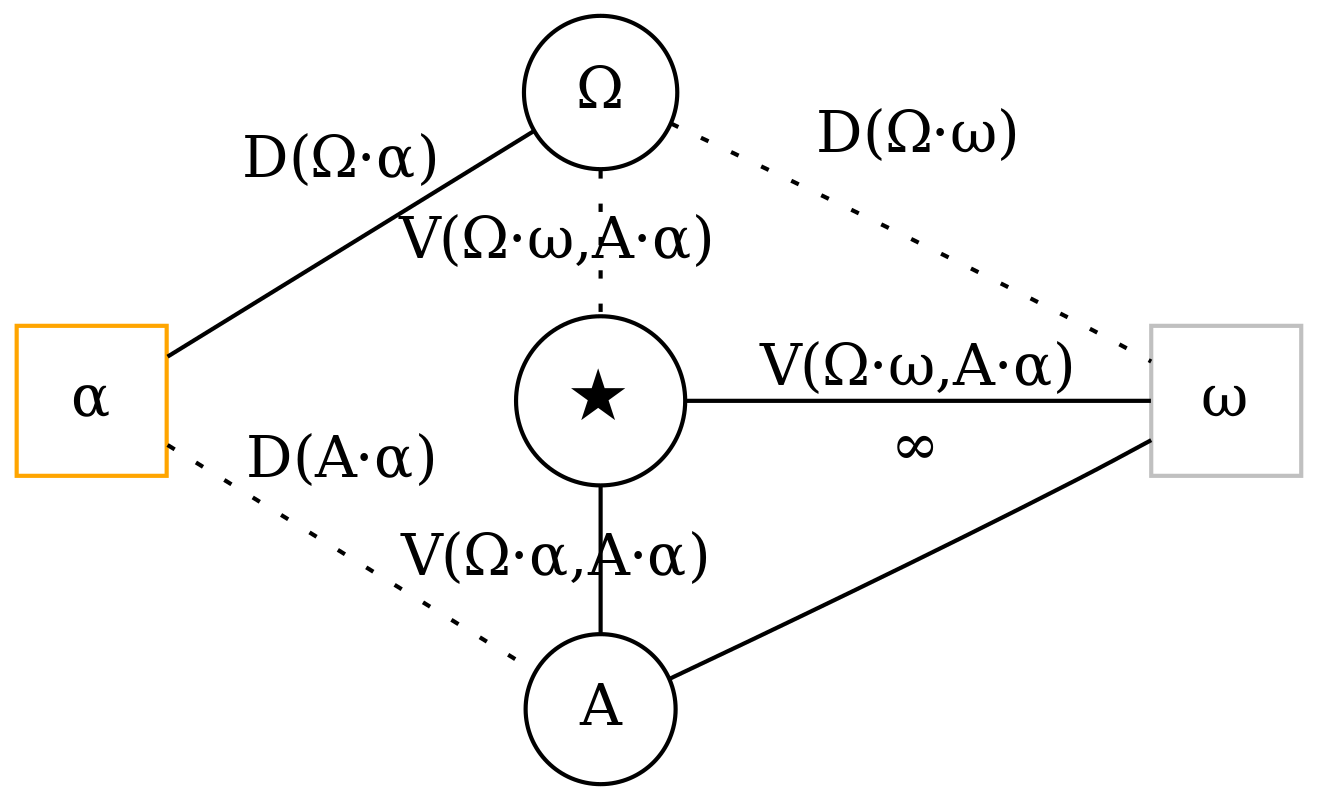

In [11]:
DOT(
    """
graph my_graph {
    rankdir=LR;
    {rank = same; "A"; "★"; "Ω"}
    "α" [shape=square color=orange];
    "ω" [shape=square color=grey];
    "Ω" [shape=circle];
    "A" [shape=circle];
    "★" [shape=circle];
    "α" -- "Ω" [label="D(Ω·α)"];
    "Ω" -- "ω" [label="D(Ω·ω)" style=dotted];
    "α" -- "A" [label="D(A·α)" style=dotted];
    "A" -- "ω" [label="∞"];
    "★" -- "A" [label="V(Ω·α,A·α)"]
    "Ω" -- "★" [label="V(Ω·ω,A·α)" style=dotted];
    "★" -- "ω" [label="V(Ω·ω,A·α)"]
}
"""
)

The choice of weights is the fundamental mechanism by which the expansion-move algorithm operates. The rules for finding these values are given in {cite:ps}`delong_fast_2010`.

Clearly, the cut illustrated in {numref}`graph-expansion-ocean-cut` yields the correct cost. However, how does this cut invoke a new labelling? One implication of the property 
> no proper subset of {math}`\mathcal{C}` may also be a cut

is that exactly _one_ edge between the terminals ({math}`\{\,\omega, \alpha\,\}`) and any node can be cut.{cite:ps}`boykov_fast_2001-1` This naturally defines a correspondence between a cut and a labelling: the cutting of a terminal edge assigns the corresponding label to the node. In this case, we have a cut through {math}`\alpha-A` and {math}`\omega-\Omega`, which assigns label {math}`\alpha` to {math}`A` and {math}`\Omega` to {math}`\omega` respectively. Hence, the edge with a cost of {math}`\infty` is required in order to satisfy the expanding-only property of the expansion-move; it will never be favourable to cut these edges, i.e. the primary label {math}`\alpha` for a given expansion will never be reassigned from.

Our simple model only considers two labels ({math}`\lvert F \rvert = 2`), whilst in practice {math}`\lvert F \rvert \gg 2`. To generalise the expansion of label {math}`\alpha` to {math}`\lvert F \rvert > 2`, we can replace {math}`\omega` with a _meta_ label {math}`\overline{\alpha}` that represents not-{math}`\alpha`. Thereafter, the procedure remains identical. In order to determine the optimum expansion-move, we must repeat this procedure for each label.

The {math}`\alpha`-expansion algorithm is therefore

1. Build a graph {math}`\mathcal{G}_\alpha(\mathcal{V}_\alpha, \mathcal{E}_\alpha)` composed of a set of vertices {math}`\mathcal{V}_\alpha` and a set of pairwise edges {math}`\mathcal{E}_\alpha`. 
2. Add a pair of additional _terminal_ vertices {math}`\alpha` and {math}`\overline{\alpha}` that represent the {math}`\alpha` label and the set of complement labels {math}`\overline{\alpha}=F - \{\,\alpha\,\}`.
3. Establish a _weight_ for each edge in {math}`\mathcal{E}_\alpha`.
4. Determine the minimum cut of {math}`\mathcal{G}(\mathcal{V}, \mathcal{E})` to propose a new labelling.
5. Accept the new labelling if the cost of the cut, which is equivalent to {eq}`cost-function-graph`, is lower than the existing solution.
6. Go to 1. for the next label.

It can be shown that this algorithm can be generalised to account for label costs in order to solve {eq}`cost-function-pearl`.{cite:ps}`delong_fast_2010`

A condition of the {math}`\alpha`-expansion method is that the interaction potential between labels be _metric_, i.e. it must satisfy{cite:ps}`boykov_fast_2001-1`

:::{math}
V_{\alpha, \beta} &\leq V_{\alpha, \gamma} + V_{\gamma, \beta}

V_{\alpha, \beta} &= V_{\beta, \alpha} \geq 0\,.
:::

The choice of a {math}`V_{\alpha, \gamma}=\delta_{\alpha\gamma}` interaction potential (the Potts model) combined with a geometric distance meets this requirement.{cite:ps}`isack_energy-based_2012`

### PeARL

So far, we have explored the application of graph-cuts to solving the metric labelling problem. It is not immediately obvious how this approach maps onto the problem of track fitting. At first glance, the model {math}`f` seen in {eq}`cost-function-pearl` resembles the label described in {ref}`alpha-expansion`. However, our track models are members of {math}`\mathcal{L}=\mathbb{R}^n`, and therefore a one-to-one mapping between {math}`F` and {math}`\mathcal{L}` would be infinitely large. In order to explore the continuum of model parameters whilst working within a feasible subset of the parameter space, the PeARL algorithm may be used.{cite:ps}`boykov_fast_2001-1` 

:::{mermaid}
:caption: Process diagram of the PeARL algorithm
:name: pearl-algorithm

graph LR
    propose["(1) Propose labelling F"]
    expand["(2) Expand labelling F to F'"]
    reestimate["(3) Re-estimate models"]
    propose --> expand
    expand --> reestimate
    reestimate --> expand
:::

A process diagram for the PeARL algorithm is shown in {numref}`pearl-algorithm`, and is comprised of the following steps:

1. *Propose* an initial set of models {math}`\mathcal{L}_0` by random sampling from a set of observations
2. Compute the optimal labelling {math}`F_t` from {math}`\mathcal{L}_t` by *expanding* each label {math}`f \in F`
3. *Re-estimate* the model parameters of {math}`\mathcal{L}_t` using {math}`F_t` to find {math}`\mathcal{L}_{t+1}`; go to (2.)

The proposal step (1) of the PeARL algorithm closely resembles that of RANSAC. Unlike RANSAC, however, PeARL evaluates these proposals against a single optimization objective, rather than hierarchically. 

### Track Fitting

#### Unbounded Line
Conventional track fitting approaches often model a track as an unbounded line in three dimensional space. Such a model has an non-normalisable probability density; naturally over an infinite interval, the probability of observing any particular value approaches 0. As such, it is not appropriate (or indeed possible) to use the log-likelihood in {eq}`log-likelihood-sum` to describe the data cost required by {eq}`cost-function-pearl`. Instead, a simple orthogonal displacement cost function can be used
:::{math}
T_{fc} = k\frac{\norm{\left(\vb{r}(c) - \vb{o}(f)\right)\wedge \hat{\vb{n}}(f)}^2}{\sigma(f)^2}\,,
:::
where {math}`\vb{r}(c)` is the position of observation {math}`c`, {math}`\vb{o}(f)` a point belonging to model {math}`f`, {math}`\hat{\vb{n}}(f)` the direction of model {math}`f`, {math}`\sigma(f)` the width of the transverse distribution, and {math}`k` a scaling factor. This corresponds to the residual shown in {numref}`track-model-illustration`.

#### Line Segment
Another model applicable to track fitting is to treat a set of observations as a line _interval_. 
With a finite length, the model has a normalisable probability density, and as such the log likelihood can be used to determine the data cost.

A curve can be defined as an infinite sum of point distributions, where the probability {math}`p(\va{r})` of observing {math}`\va{r}` is
:::{math}
:label: p-point-curve

p(\va{r}) = \int_L f(\va{r};\va*{\mu}(t) ,\va*{\Sigma})\dd{t}\,.
:::
The PDF for a non-degenerate multivariate normal distribution is
:::{math}
:label: pdf-multivariate-point

{ f(\va{r})={\frac {\exp \left(-{\frac {1}{2}}({\va {r} }-{\va*{\mu }})^{\mathrm {T} }{\va*{\Sigma }}^{-1}({\va {r} }-{\va*{\mu }})\right)}{\sqrt {(2\pi )^{k} \abs{{\va*{\Sigma }}} }}}}\,,
:::

for $\va{r}\in\mathbb{R}^k$, where ${\va*{\Sigma }}$ is a symmetric matrix. For a line interval of normally distributed points, bounded between {math}`t\in [0, 1]`, {eq}`p-point-curve` simplifies to 

:::{math}
:label: p-point-multivariate-line

p(\va{r}) = \int_0^1{{\frac {\exp \left(-{\frac {1}{2}}({\va {r} }-\va*{\mu}(t))^{\mathrm {T} }{\va*{\Sigma }}^{-1}({\va {r} }-\va*{\mu}(t))\right)}{\sqrt {(2\pi )^{k} \abs{{\va *{\Sigma }}}}}}\dd{t}}\,.
:::

With considerations for symmetry, it can be shown that the log of the integral in {eq}`p-point-multivariate-line` reduces to
:::{math}
:label: p-point-line-solution

p(\va{r}) = \underbrace{\log\pqty{\frac{1}{4\pi L\sigma^2}}}_{\text{length penalty}} +
            \underbrace{\log\left(\operatorname{erfc} \bqty{\frac{1}{\sqrt{2}\sigma}\pqty{\abs{\Delta\va{r}\cdot \vu{n} - \frac{L}{2}} - \frac{L}{2}}}\right)}_{\text{end-point penalty}} +
            \underbrace{\frac{1}{2\sigma^2}\bqty{\pqty{\Delta\va{r}\cdot \vu{n}}^2 - \Delta\va{r}\cdot\Delta\va{r}}}_{\text{orthogonal distance penalty}}\,,
:::
where {math}`L` is the length of the line, {math}`\vu{n}` is the unit direction of the line, and {math}`\Delta\va{r}` the relative position of {math}`\va{r}` with respect to the line origin.

::::{admonition} Derivation of {eq}`p-point-line-solution`
:class: dropdown

Consider the expanded integral:
:::{math}
\begin{aligned}
p(\mathbf{r}) 
    &= \left(\frac{1}{\sigma\sqrt{2\pi}}\right)^3 
        \int_0^1 {
        \exp\!\left[{-\frac{\left(x - \left(a_x + (b_x-a_x)t\right)\right)^2}{2\sigma^2}}\right]
        \exp\!\left[{-\frac{\left(y - \left(a_y + (b_y-a_y)t\right)\right)^2}{2\sigma^2}}\right]
        \exp\!\left[{-\frac{\left(z - \left(a_z + (b_z-a_z)t\right)\right)^2}{2\sigma^2}}\right]
        }\,dt\\
    &= \left(\frac{1}{\sigma\sqrt{2\pi}}\right)^3 
        \int_0^1 {
        \exp\!\left[{-\frac{\left(d_x - n_xLt\right)^2}{2\sigma^2}}\right]
        \exp\!\left[{-\frac{\left(d_y - n_yLt\right)^2}{2\sigma^2}}\right]
        \exp\!\left[{-\frac{\left(d_z - n_zLt\right)^2}{2\sigma^2}}\right]
        }\,dt\,.\\
\end{aligned}
:::

First, let's define our integrand, and simplify the arguments according to

:::{math}
\begin{matrix}
a = \frac{d_x}{\sqrt{2}\sigma} &
A = \frac{n_xL}{\sqrt{2}\sigma} \\
b = \frac{d_y}{\sqrt{2}\sigma} &
B = \frac{n_yL}{\sqrt{2}\sigma} \\
c = \frac{d_z}{\sqrt{2}\sigma} &
C = \frac{n_zL}{\sqrt{2}\sigma} \\
\end{matrix}
:::

Wolfram gives the solution as 
:::{math}
\frac{\sqrt{\pi} \left(\operatorname{erf}{\left(\frac{A a + B b + C c}{\sqrt{A^{2} + B^{2} + C^{2}}} \right)} + \operatorname{erf}{\left(\frac{A^{2} - A a + B^{2} - B b + C^{2} - C c}{\sqrt{A^{2} + B^{2} + C^{2}}} \right)}\right) e^{- a^{2} - b^{2} - c^{2} + \frac{\left(A a + B b + C c\right)^{2}}{A^{2} + B^{2} + C^{2}}}}{2 \sqrt{A^{2} + B^{2} + C^{2}}}\,.
:::

Now, we must restore our original parameters,
:::{math}
\begin{matrix}
a = \frac{d_x}{\sqrt{2}\sigma} &
A = \frac{n_xL}{\sqrt{2}\sigma} \\
b = \frac{d_y}{\sqrt{2}\sigma} &
B = \frac{n_yL}{\sqrt{2}\sigma} \\
c = \frac{d_z}{\sqrt{2}\sigma} &
C = \frac{n_zL}{\sqrt{2}\sigma} \\
\end{matrix}
:::

which gives
:::{math}
\frac{\sqrt{2} \sqrt{\pi} \sigma \left(\operatorname{erf}{\left(\frac{\sqrt{2} \left(d_{x} n_{x} + d_{y} n_{y} + d_{z} n_{z}\right)}{2 \sigma \sqrt{n_{x}^{2} + n_{y}^{2} + n_{z}^{2}}} \right)} + \operatorname{erf}{\left(\frac{\sqrt{2} \left(L n_{x}^{2} + L n_{y}^{2} + L n_{z}^{2} - d_{x} n_{x} - d_{y} n_{y} - d_{z} n_{z}\right)}{2 \sigma \sqrt{n_{x}^{2} + n_{y}^{2} + n_{z}^{2}}} \right)}\right) e^{\frac{- \left(d_{x}^{2} + d_{y}^{2} + d_{z}^{2}\right) \left(n_{x}^{2} + n_{y}^{2} + n_{z}^{2}\right) + \left(d_{x} n_{x} + d_{y} n_{y} + d_{z} n_{z}\right)^{2}}{2 \sigma^{2} \left(n_{x}^{2} + n_{y}^{2} + n_{z}^{2}\right)}}}{2 L \sqrt{n_{x}^{2} + n_{y}^{2} + n_{z}^{2}}}
:::

We know that {math}`\lvert{n}\rvert=1`, so let's restore the factored coefficient, and apply this simplification:

:::{math}
\frac{\left(\operatorname{erf}{\left(\frac{\sqrt{2} \left(d_{x} n_{x} + d_{y} n_{y} + d_{z} n_{z}\right)}{2 \sigma} \right)} + \operatorname{erf}{\left(\frac{\sqrt{2} \left(L n_{x}^{2} + L n_{y}^{2} + L n_{z}^{2} - d_{x} n_{x} - d_{y} n_{y} - d_{z} n_{z}\right)}{2 \sigma} \right)}\right) e^{\frac{- d_{x}^{2} - d_{y}^{2} - d_{z}^{2} + \left(d_{x} n_{x} + d_{y} n_{y} + d_{z} n_{z}\right)^{2}}{2 \sigma^{2}}}}{4 \pi L \sigma^{2}}
:::

Then we can simplify with known geometric identities

:::{math}
\frac{\left(\operatorname{erf}{\left(\frac{\sqrt{2} d_{dot n}}{2 \sigma} \right)} + \operatorname{erf}{\left(\frac{\sqrt{2} \left(L - d_{dot n}\right)}{2 \sigma} \right)}\right) e^{\frac{d_{dot n}^{2} - d_{mag2}}{2 \sigma^{2}}}}{4 \pi L \sigma^{2}}
:::
::::

A visualisation of this likelihood function can be see in {numref}`volume-likelihood-interval`.

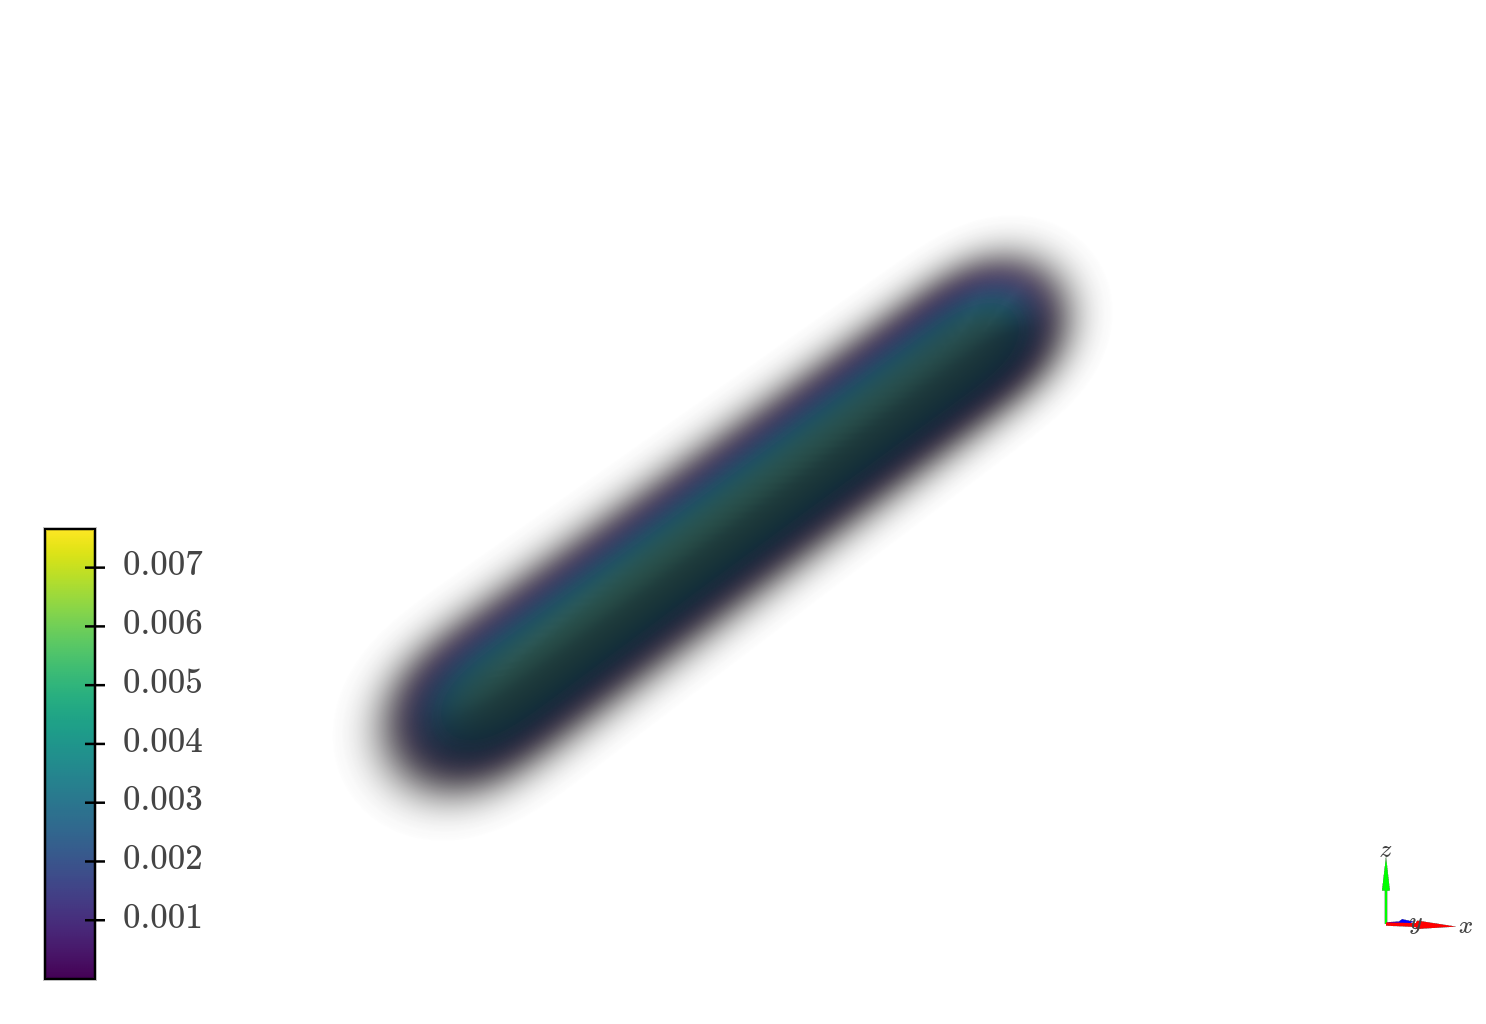

In [12]:
X, Y, Z = np.mgrid[0:20:100j, 0:20:100j, 0:20:100j]
R = np.stack((X, Y, Z), axis=-1)
cost_1 = probability_point_line(R, np.r_[4, 4, 4], np.r_[16, 16, 16], sigma=1.0)

figure = k3d.plot(camera_auto_fit=False, grid_auto_fit=False, grid_visible=False)
figure += k3d.volume(
    cost_1.astype(np.float32), color_map=k3d.matplotlib_color_maps.Viridis
)
figure.camera = [
    0.7074783171639407,
    -1.0612174757459112,
    0.07074783171639523,
    0,
    0,
    0,
    0,
    0,
    1,
]

# Provide image fallback
with capture_output() as c:
    display(figure, Image("image/probability-line-interval.png"))

display(c.outputs[0].data | c.outputs[1].data, raw=True)

## Kinematic Fitting

:::{note}
:class: margin

Should we look at GNN / CA methods here?
:::

:::{admonition} To Do
CPA?
:::